<a href="https://colab.research.google.com/github/NikhilManjunath/Image-Super-Resolution-using-GAN/blob/main/srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing the required libraries
import torch
from torch.utils.data import * 
import torch.nn as nn
import torchvision 
import glob
import os
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import seaborn as sn
from torch.utils.data import Dataset
import glob
import os
from PIL import Image
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from torchvision.models import vgg19
from sklearn.model_selection import KFold
from pathlib import Path

In [ ]:
# !rm -rf DIV2K_train_HR/
# !rm -rf DIV2K_train_LR_bicubic/
# !rm -rf DIV2K_valid_HR/
# !rm -rf DIV2K_valid_LR_bicubic/
# !rm -rf sr_img/

In [2]:
#Downloading the Dataset
!wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
!wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
!wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip"
!wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip"

--2022-05-12 00:31:18--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2022-05-12 00:31:18--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M  17.2MB/s    in 31s     

2022-05-12 00:31:49 (14.0 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]

--2022-05-12 00:31:50--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (d

In [ ]:
#Unzipping the datafiles downloaded
!unzip DIV2K_train_LR_bicubic_X2.zip
!unzip DIV2K_valid_HR
!unzip DIV2K_valid_LR_bicubic_X2.zip
!unzip DIV2K_train_HR.zip

In [ ]:
TRAIN_HR_DIR = "./DIV2K_train_HR"
TRAIN_LR_DIR = "./DIV2K_train_LR_bicubic/X2"
TEST_HR_DIR = "./DIV2K_valid_HR"
TEST_LR_DIR = "./DIV2K_valid_LR_bicubic/X2"

In [ ]:
#Defining the model parameters
LR_CROPPED_SIZE = 100
UPSCALE = 2
HR_CROPPED_SIZE = UPSCALE * LR_CROPPED_SIZE

REAL_VALUE = 0.99
FAKE_VALUE = 0.0

BATCH_SIZE = 16
EPOCHS = 40

N_RESBLK_G = 20
LR = 0.0001
BETAS = (0.9,0.9999)

VGG_LOSS_COEF = 0.006
ADVERSARIAL_LOSS_COEF = 0.001

In [ ]:
#Defining a class
class DIV2K(Dataset):
	def __init__(self, data_dir, transform=transforms.ToTensor()):
		# Get all paths of images inside `data_dir` into a list
		pattern = os.path.join(data_dir, "**/*.png")
		self.file_paths = sorted(glob.glob(pattern, recursive=True))
		self.transform = transform

	def __len__(self):
		return len(self.file_paths)

	def __getitem__(self, index):
		file_name = self.file_paths[index].split('/')[-1]
		img = Image.open(self.file_paths[index])
		img = self.transform(img)
		return img, file_name

In [ ]:
#Defining a Generator Class
class Generator(nn.Module):
	def __init__(self, n_res_blks, upscale_factor=2):
		super(Generator, self).__init__()

		#Convolutional layer
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
		self.prelu1 = nn.PReLU()

		#Residual Block
		self.res_blocks = nn.Sequential()
		for i in range(n_res_blks):
			self.res_blocks.add_module(f"res_blk_{i}",
									   Residual_Block(in_channels=64, out_channels=64,strides=1, use_1x1_conv=False))
		self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
		self.bn = nn.BatchNorm2d(64)

		#Pixel Shuffler
		self.pixel_shufflers = nn.Sequential()
		for i in range(1):
			self.pixel_shufflers.add_module(f"pixel_shuffle_blk_{i}",
											PixelShufflerBlock(in_channels=64, upscale_factor=upscale_factor))
		self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, padding=4)

	#Defining how the generator model will be run
	def forward(self, X):
		X = self.prelu1(self.conv1(X))
		X_before_resblks = X.clone()

		X = self.res_blocks(X)
		X = self.bn(self.conv2(X))
		#Skip Connections
		X = F.relu(X + X_before_resblks)
		X = self.pixel_shufflers(X)
		
		X = self.conv3(X)
		
		return F.tanh(X)
		
#Residual Block Class
class Residual_Block(nn.Module):
	def __init__(self, in_channels, out_channels, strides, use_1x1_conv=True):
		super(Residual_Block, self).__init__()

		self.use_1x1_conv = use_1x1_conv
		self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
		self.blk = nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
			nn.BatchNorm2d(out_channels),
			nn.PReLU(),
			nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_channels),
		)

	#Defninig how the Residual block will be run
	def forward(self, X):
		"""
		:param X: tensor with shape (N, C, H, W)
		"""
		X_original = X.clone()
		X = self.blk(X)
		if self.use_1x1_conv:
			X_original = self.conv1x1(X_original)

		return F.relu(X + X_original)

#Pixel Shuffler class
class PixelShufflerBlock(nn.Module):
	def __init__(self, in_channels, upscale_factor=2):
		super(PixelShufflerBlock, self).__init__()

		self.blk = nn.Sequential(
			nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=3, padding=1),
			nn.PixelShuffle(upscale_factor=upscale_factor),
			nn.PReLU()
		)

	def forward(self, X):
		return self.blk(X)

In [ ]:
#Defining a Discriminator Class
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()

		self.conv1 = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
			nn.LeakyReLU(negative_slope=0.2)
		)
		#Convolutional Blocks
		self.conv_blks = nn.Sequential(
			ConvBlock(64, 64, 2),
			ConvBlock(64, 128, 1),
			ConvBlock(128, 128, 2),
			ConvBlock(128, 256, 1),
			ConvBlock(256, 256, 2),
			ConvBlock(256, 512, 1),
			ConvBlock(512, 512, 2)
		)
		self.global_pooling = nn.AdaptiveAvgPool2d(output_size=1)
		self.conv2 = nn.Sequential(
			nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
			nn.LeakyReLU(negative_slope=0.2)
		)
		self.conv3 = nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=1)

	def forward(self, X):
		X = self.conv1(X)
		X = self.conv_blks(X)
		X = self.global_pooling(X)
		X = self.conv2(X)
		X = self.conv3(X)
		X = X.flatten(start_dim=1)
		return F.sigmoid(X)

class ConvBlock(nn.Module):
	def __init__(self, in_channels, out_channels, strides=1):
		super(ConvBlock, self).__init__()
		self.blk = nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
			nn.BatchNorm2d(out_channels),
			nn.LeakyReLU(negative_slope=0.2)
		)

	def forward(self, X):
		return self.blk(X)

In [ ]:
#Transforming the images by cropping them
transform_hr = transforms.Compose([
	transforms.CenterCrop(HR_CROPPED_SIZE),
	transforms.ToTensor()
])
transform_lr = transforms.Compose([
	transforms.CenterCrop(LR_CROPPED_SIZE),
	transforms.ToTensor()
])

In [ ]:
#Defining a class to calculate perceptual loss, adverserial loss and vgg loss
class PerceptualLoss(nn.Module):
	def __init__(self, vgg_coef, adversarial_coef):
		super(PerceptualLoss, self).__init__()
		_vgg19 = vgg19(pretrained=True)
		self.vgg19 = nn.Sequential(*_vgg19.features).eval()
		for p in self.vgg19.parameters():
			p.requires_grad = False
		self.euclidean_distance = nn.MSELoss()
		self.vgg_coef = vgg_coef
		self.adversarial_coef = adversarial_coef

	def forward(self, sr_img, hr_img, output_labels):
		adversarial_loss = torch.mean(1-output_labels)
		vgg_loss = self.euclidean_distance(self.vgg19(sr_img), self.vgg19(hr_img))
		pixel_loss = self.euclidean_distance(sr_img, hr_img)
		return pixel_loss, self.adversarial_coef*adversarial_loss, self.vgg_coef*vgg_loss

In [ ]:
#Creating paths to store checkpoints for the Generator and Discriminator so that the training can be continued if stopped unexpectedly
PATH_G = Path("./model/G.pt")
PATH_D = Path("./model/D.pt")

device: CUDA
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 100, 100]          15,616
             PReLU-2         [16, 64, 100, 100]               1
            Conv2d-3         [16, 64, 100, 100]          36,928
       BatchNorm2d-4         [16, 64, 100, 100]             128
             PReLU-5         [16, 64, 100, 100]               1
            Conv2d-6         [16, 64, 100, 100]          36,928
       BatchNorm2d-7         [16, 64, 100, 100]             128
    Residual_Block-8         [16, 64, 100, 100]               0
            Conv2d-9         [16, 64, 100, 100]          36,928
      BatchNorm2d-10         [16, 64, 100, 100]             128
            PReLU-11         [16, 64, 100, 100]               1
           Conv2d-12         [16, 64, 100, 100]          36,928
      BatchNorm2d-13         [16, 64, 100, 100]             128
   Residual_Block-14      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


      BatchNorm2d-61         [16, 64, 100, 100]             128
   Residual_Block-62         [16, 64, 100, 100]               0
           Conv2d-63         [16, 64, 100, 100]          36,928
      BatchNorm2d-64         [16, 64, 100, 100]             128
            PReLU-65         [16, 64, 100, 100]               1
           Conv2d-66         [16, 64, 100, 100]          36,928
      BatchNorm2d-67         [16, 64, 100, 100]             128
   Residual_Block-68         [16, 64, 100, 100]               0
           Conv2d-69         [16, 64, 100, 100]          36,928
      BatchNorm2d-70         [16, 64, 100, 100]             128
            PReLU-71         [16, 64, 100, 100]               1
           Conv2d-72         [16, 64, 100, 100]          36,928
      BatchNorm2d-73         [16, 64, 100, 100]             128
   Residual_Block-74         [16, 64, 100, 100]               0
           Conv2d-75         [16, 64, 100, 100]          36,928
      BatchNorm2d-76         [16, 64, 10

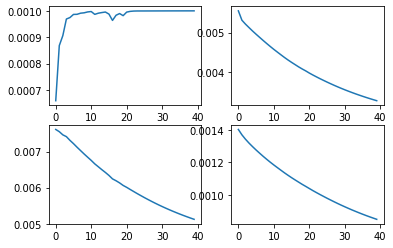

In [ ]:
#Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {str(device).upper()}")

def train(resume_training=True):
	#Loading the data
	data_train_hr, data_train_lr = load_training_data()
	hr_train_loader = DataLoader(dataset=data_train_hr, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
	lr_train_loader = DataLoader(dataset=data_train_lr, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
	assert len(hr_train_loader) == len(lr_train_loader)

	#Loading the models
	G = Generator(n_res_blks=N_RESBLK_G, upscale_factor=UPSCALE).to(device)
	D = Discriminator().to(device)
	optimizer_G = optim.Adam(G.parameters(), lr=LR, betas=BETAS)
	optimizer_D = optim.Adam(D.parameters(), lr=LR, betas=BETAS)

	#Save Checkpoints
	if resume_training and PATH_G.exists() and PATH_D.exists():
			G, D, optimizer_G, optimizer_D, prev_epochs = load_checkpoints(G, D, optimizer_G, optimizer_D)
			print("Continue training from previous checkpoints ...")
			warmup = False
	else:
		G.apply(xavier_init_weights)
		D.apply(xavier_init_weights)
		prev_epochs = 0
		summary(G, input_size=(3, LR_CROPPED_SIZE, LR_CROPPED_SIZE), batch_size=BATCH_SIZE, device=str(device))
		summary(D, input_size=(3, HR_CROPPED_SIZE, HR_CROPPED_SIZE), batch_size=BATCH_SIZE, device=str(device))
		print("Training from start ...")
		warmup = True

	#Training
	G.train()
	D.train()

	#Loss
	criterion_G = PerceptualLoss(vgg_coef=VGG_LOSS_COEF, adversarial_coef=ADVERSARIAL_LOSS_COEF).to(device)
	warmup_loss = torch.nn.L1Loss()
	criterion_D = torch.nn.BCELoss()
	epoch_pixel_loss = []
	epoch_adversial_loss =[]
	epoch_vgg_loss =[]
	epoch_error_G =[]
	#Warming up the Generator
	if warmup:
		for w in range(10):
			print(f"\nWarmup: {w+1}")
			for (batch, hr_batch), lr_batch in zip(enumerate(hr_train_loader), lr_train_loader):
				hr_img, lr_img = hr_batch[0].to(device), lr_batch[0].to(device)
				optimizer_G.zero_grad()

				sr_img = G(lr_img)
				err_G = warmup_loss(sr_img, hr_img)
				err_G.backward()
				optimizer_G.step()
				if batch % 10 == 0:
					print(f"\tBatch: {batch + 1}/{len(data_train_hr) // BATCH_SIZE}")
					print(f"\tMAE G: {err_G.item():.4f}")

	#Epochs
	for e in range(EPOCHS):
		batch_adversarial_loss=0
		batch_pixel_loss = 0
		batch_vgg_loss =0 
		batch_error_G = 0
		print(f"\nEpoch: {e+prev_epochs+1}")
		n_batches = 0
		for (batch, hr_batch), lr_batch in zip(enumerate(hr_train_loader), lr_train_loader):
			n_batches+=1
			# Transfer data to GPU if available
			hr_img, lr_img = hr_batch[0].to(device), lr_batch[0].to(device)

			#Training Discriminator to maximize log(D(x)) + log(1-D(G(z)))
			optimizer_D.zero_grad()

			# Classify all-real HR images
			real_labels = torch.full(size=(len(hr_img),), fill_value=REAL_VALUE, dtype=torch.float, device=device)
			output_real = D(hr_img).view(-1)
			err_D_real = criterion_D(output_real, real_labels)
			err_D_real.backward()

			# Classify all-fake HR images (or SR images)
			fake_labels = torch.full(size=(len(hr_img),), fill_value=FAKE_VALUE, dtype=torch.float, device=device)
			sr_img = G(lr_img)
			
			output_fake = D(sr_img.detach()).view(-1)
			err_D_fake = criterion_D(output_fake, fake_labels)
			err_D_fake.backward()

			optimizer_D.step()
			D_Gz1 = output_fake.mean().item()

			#Training Generator to minimize log(D(G(z))
			optimizer_G.zero_grad()

			output_fake = D(sr_img).view(-1)
			pixel_loss, adversarial_loss, vgg_loss = criterion_G(sr_img, hr_img, output_fake)
			err_G = pixel_loss + adversarial_loss + vgg_loss
			err_G.backward()

			optimizer_G.step()
			batch_adversarial_loss += adversarial_loss.item()
			batch_pixel_loss += pixel_loss.item()
			batch_vgg_loss +=vgg_loss.item()
			batch_error_G +=err_G.item()
			# Print stats
			if batch%10==0:
				print(f"\tBatch: {batch + 1}/{len(data_train_hr) // BATCH_SIZE}")
				D_x = output_real.mean().item()
				D_Gz2 = output_fake.mean().item()
				print(f"\terr_D_real: {err_D_real.item():.4f}; err_D_fake: {err_D_fake.item():.4f}; "
					f" err_G: {err_G.item():.4f}; D_x: {D_x:.4f}; D_Gz1: {D_Gz1:.4f}; D_Gz2: {D_Gz2:.4f}")
				print(f"\t adversarial_loss: {adversarial_loss:.4f}, vgg_loss: {vgg_loss:.4f}, "
					f"pixel_loss: {pixel_loss:.4f}")
			## Free up GPU memory
			del hr_img, lr_img, err_D_fake, err_D_real, err_G, real_labels, fake_labels, \
				output_real, output_fake, sr_img, pixel_loss, adversarial_loss, vgg_loss
			torch.cuda.empty_cache()
		epoch_adversial_loss.append(batch_adversarial_loss/n_batches)
		epoch_pixel_loss.append(batch_pixel_loss/n_batches)
		epoch_error_G.append(batch_error_G/n_batches)
		epoch_vgg_loss.append(batch_vgg_loss/n_batches)
		n_batches = 0
		#Save checkpoints
		save_checkpoints(G, D, optimizer_G, optimizer_D, epoch=prev_epochs+e+1)
	
	#Plotting errors 
	plt.subplot(2,2,1)
	plt.plot(epoch_adversial_loss)
	plt.subplot(2,2,2)
	plt.plot(epoch_pixel_loss)
	plt.subplot(2,2,3)
	plt.plot(epoch_error_G)
	plt.subplot(2,2,4)
	plt.plot(epoch_vgg_loss)
	plt.show()

def save_checkpoints(G, D, optimizer_G, optimizer_D, epoch):
	checkpoint_G = {
		'model': G,
		'state_dict': G.state_dict(),
		'optimizer': optimizer_G.state_dict(),
		'epoch': epoch
	}
	checkpoint_D = {
		'model': D,
		'state_dict': D.state_dict(),
		'optimizer': optimizer_D.state_dict(),
	}
	torch.save(checkpoint_G, PATH_G)
	torch.save(checkpoint_D, PATH_D)
 
def load_checkpoints(G, D, optimizerG, optimizerD):
	print("Loading checkpoints ...")
	checkpoint_G = torch.load(PATH_G)
	checkpoint_D = torch.load(PATH_D)
	G.load_state_dict(checkpoint_G['state_dict'])
	optimizerG.load_state_dict(checkpoint_G['optimizer'])
	D.load_state_dict(checkpoint_D['state_dict'])
	optimizerD.load_state_dict(checkpoint_D['optimizer'])
	prev_epochs = checkpoint_G['epoch']
	print("Loaded checkpoints successfully!")
	return G, D, optimizerG, optimizerD, prev_epochs	 

def load_training_data():
	data_train_hr = DIV2K(data_dir=os.path.join("./", TRAIN_HR_DIR), transform=transform_hr)
	data_train_lr = DIV2K(data_dir=os.path.join("./", TRAIN_LR_DIR), transform=transform_lr)
	return data_train_hr, data_train_lr

def xavier_init_weights(model):
	if isinstance(model, torch.nn.Linear) or isinstance(model, torch.nn.Conv2d):
		torch.nn.init.xavier_uniform_(model.weight)

if __name__ == "__main__":
	train()



In [ ]:
#Testing on the Test Set -> The SR images generated are saved in the 'sr_img' folder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SR_DIR = "./sr_img"

def generate_sr(lr_img_path):
	with torch.no_grad():
		pil_img = Image.open(lr_img_path)
		img_tensor = transforms.ToTensor()(pil_img)
		img_tensor = torch.unsqueeze(img_tensor, 0) # add batch dimension
		img_tensor = img_tensor.to(device)
		sr_img = G(img_tensor)
		print(f"Upscaled from size [{img_tensor.shape[2]}, {img_tensor.shape[3]}] to [{sr_img.shape[2]}, {sr_img.shape[3]}]")

	file_name = lr_img_path.split('/')[-1]
	sr_img_path = os.path.join(SR_DIR, f"sr_{file_name}")
	tensor_to_img(sr_img, sr_img_path)

def tensor_to_img(tensor, filepath):
	tensor = tensor.cpu()
	pil = transforms.ToPILImage()(tensor.squeeze_(0))
	pil.save(filepath)
	print(f"Saved to {filepath}")

# Load checkpoints
G = Generator(n_res_blks=N_RESBLK_G, upscale_factor=UPSCALE)
if PATH_G.exists():
	checkpoint_G = torch.load(PATH_G)
	G.load_state_dict(checkpoint_G['state_dict'])
	G.to(device)
else:
	print("Checkpoints not found, using Xavier initialization.")
	G.apply(xavier_init_weights).to(device)
G.eval()
generate_sr('./DIV2K_valid_LR_bicubic/X2/0860x2.png')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Upscaled from size [768, 1020] to [1536, 2040]
Saved to ./sr_img/sr_0860x2.png
